In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

from colorclade import draw_colorclade_tree
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

from pylib._build_hstrat_surfaces import build_hstrat_surfaces
from pylib._build_path import build_path
from pylib._make_seed_coordinates import make_seed_coordinates
from pylib._pathsplot import pathsplot
from pylib.auxlib._hstrat_reconstruct_dataframe import (
    hstrat_reconstruct_dataframe,
)
from pylib.auxlib._log_context_duration import log_context_duration
from pylib.auxlib._make_hstrat_surface_dataframe import (
    make_hstrat_surface_dataframe,
)
from pylib.auxlib._make_reproducible import make_reproducible
from pylib.auxlib._shift_no_wrap import shift_no_wrap
from pylib.auxlib._transform_box_max import TransformBoxMax
from pylib.synthgeom._AttributeBoxMax import AttributeBoxMax
from pylib.synthgeom._VideoWriter import VideoWriter
from pylib.synthgeom._generate_observations import generate_observations

make_reproducible()


/usr/local/lib/python3.10/dist-packages/alifedata_phyloinformatics_convert/_impl/phytrack_Systematcs.py:7: UserWarning: ImportWarning: phylotrackpy.Systematics import failed; inserting a no-op mock for Systematics. This is likely because phylotrackpy is not installed.
  warnings.warn(


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-03-25T02:32:30.687835+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1021-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

matplotlib: 3.9.2
numpy     : 1.23.5

Watermark: 2.4.3



In [4]:
SX, SY = 400, 400
box_size = 4
crea_func = np.ones
crea_size = 10
logger = print
num_frames = 1000
dstream_algo = "dstream.tilted_algo"
dstream_S = 64
surface_transform = TransformBoxMax(box_size)


def mirror_backtrack_transform(arr, i):
    return shift_no_wrap(arr, (min(i, SX // 4), -min(i, SY // 4)), axis=(0, 1))


In [5]:
image_counter = it.count()
image_subdir = "out/dev-synthgeom-TransformBoxMax"
os.makedirs(image_subdir, exist_ok=True)


def make_gif_path():
    return f"{image_subdir}/image_{next(image_counter):04d}.gif"


In [6]:
def show_sample_observations(
    SX,
    SY,
    *,
    crea_func,
    crea_size=crea_size,
    every_nth=5,
    fps=30.0,
    logger=print,
    mirror_backtrack=False,
    mirror_backtrack_transform=mirror_backtrack_transform,
    num_frames=1000,
):

    observations = generate_observations(
        SX=SX,
        SY=SY,
        crea_func=crea_func,
        crea_size=crea_size,
        mirror_backtrack=mirror_backtrack,
        mirror_backtrack_transform=mirror_backtrack_transform,
        num_frames=num_frames,
    )
    with log_context_duration("Creating video", logger=logger):
        with VideoWriter(make_gif_path(), fps) as vid:
            vid.add_observations(observations, every_nth=every_nth)
            vid.show()

    with log_context_duration("Creating reversed video", logger=logger):
        with VideoWriter(make_gif_path(), fps) as vid:
            vid.add_observations(
                observations, every_nth=every_nth, reorder=reversed
            )
            vid.show()

    return observations


In [7]:
def show_sample_hstrat_tree(
    obvs,
    SX,
    SY,
    *,
    dstream_algo,
    dstream_S,
    logger,
    num_frames,
    surface_transform,
):
    with log_context_duration("build_hstrat_surfaces", logger=logger):
        surfaces = build_hstrat_surfaces(
            obvs,
            (SY, SX),
            dstream_algo=dstream_algo,
            dstream_S=dstream_S,
            surface_transform=surface_transform,
        )
    with log_context_duration("make_hstrat_surface_dataframe", logger=logger):
        surfaces_df = make_hstrat_surface_dataframe(
            surfaces[-1],
            num_frames + dstream_S,
            values=obvs[-1],
            dstream_algo=dstream_algo,
        )
    with log_context_duration("hstrat_reconstruct_dataframe", logger=logger):
        surfaces_phylo = hstrat_reconstruct_dataframe(
            surfaces_df[surfaces_df["value"] > 0.2],
        )
    surfaces_phylo["ancestor_list"] = [
        "[]" if id_ == ancestor_id else f"[{ancestor_id}]"
        for (id_, ancestor_id) in zip(
            surfaces_phylo["id"],
            surfaces_phylo["ancestor_id"],
        )
    ]
    with log_context_duration("draw_colorclade_tree", logger=logger):
        draw_colorclade_tree(
            surfaces_phylo,
            backend="biopython",
            label_tips=False,
            taxon_name_key="id",
        )
    plt.show()


In [8]:
seed_coordinates = make_seed_coordinates(
    x_coords=range(SX // 8, SX, SX // 4),
    y_coords=range(SY // 8, SY, SY // 4),
)


## `crea_func=np.ones` `mirror_backtrack=False`


enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 2 colors in source)


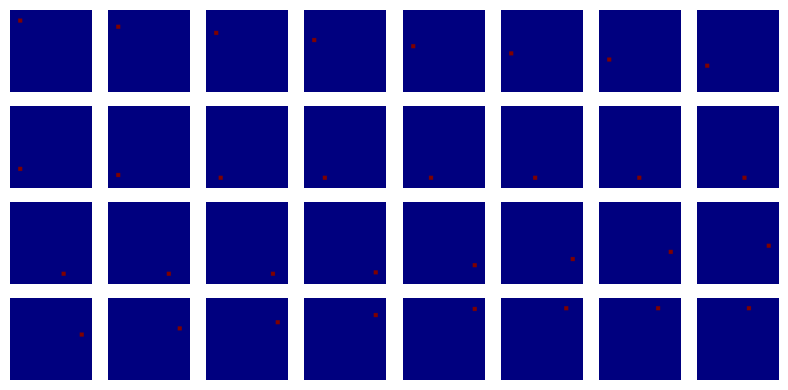

exit log_context_duration for Creating video
!!! {"Creating video": 5.229334354400635}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 2 colors in source)


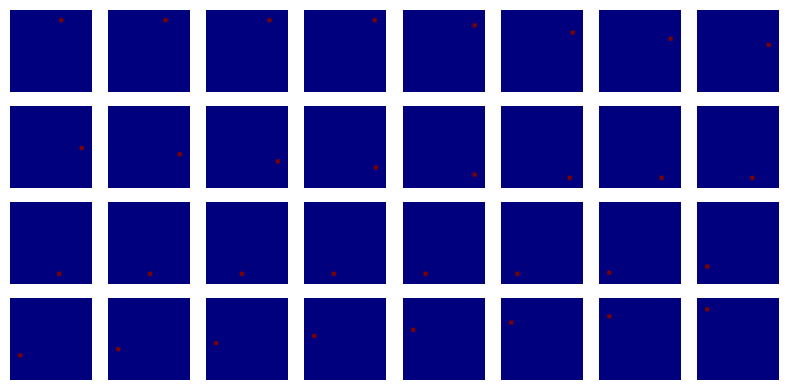

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 4.766366243362427}


100%|██████████| 16/16 [00:01<00:00, 13.90it/s]


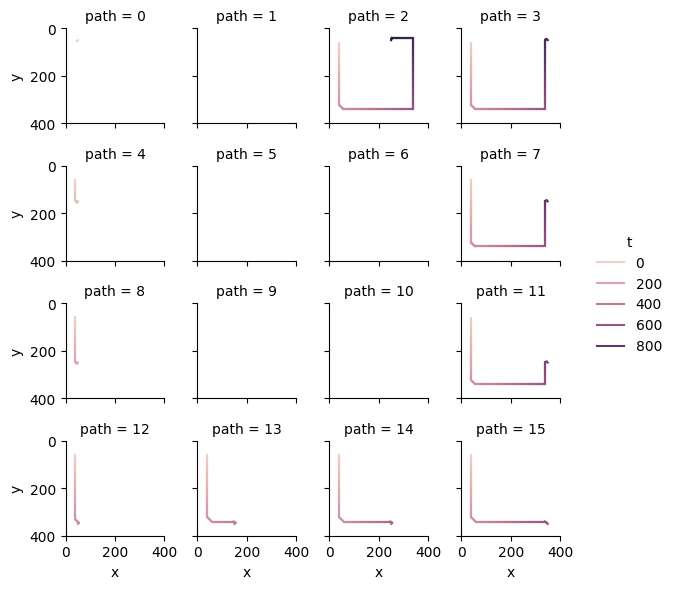

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 21.911494970321655}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.12383604049682617}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.634196281433105}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 0.8332889080047607}


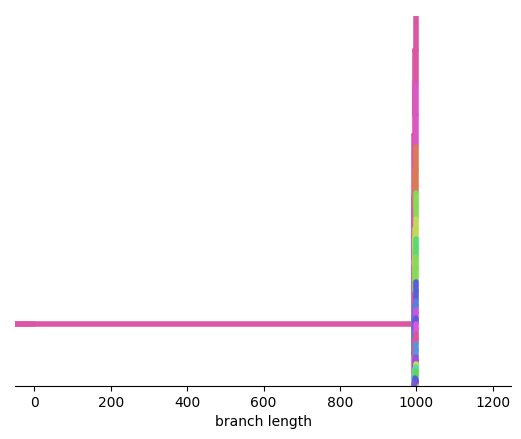

In [9]:
obvs = show_sample_observations(
    SX,
    SY,
    crea_func=np.ones,
    crea_size=crea_size,
    logger=logger,
    mirror_backtrack=False,
    num_frames=num_frames,
)
pathsplot(
    [
        build_path(coordinate, obvs, AttributeBoxMax(box_size))
        for coordinate in tqdm(seed_coordinates)
    ],
    xmax=SX,
    ymax=SY,
    col_wrap=4,
)
plt.show()

show_sample_hstrat_tree(
    obvs,
    SX,
    SY,
    dstream_algo=dstream_algo,
    dstream_S=dstream_S,
    logger=logger,
    num_frames=num_frames,
    surface_transform=surface_transform,
)


## `crea_func=np.ones` `mirror_backtrack=True`


enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 2 colors in source)


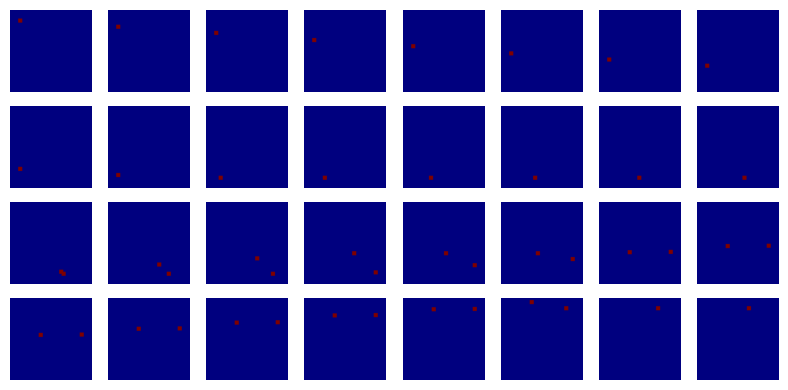

exit log_context_duration for Creating video
!!! {"Creating video": 4.928437232971191}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 2 colors in source)


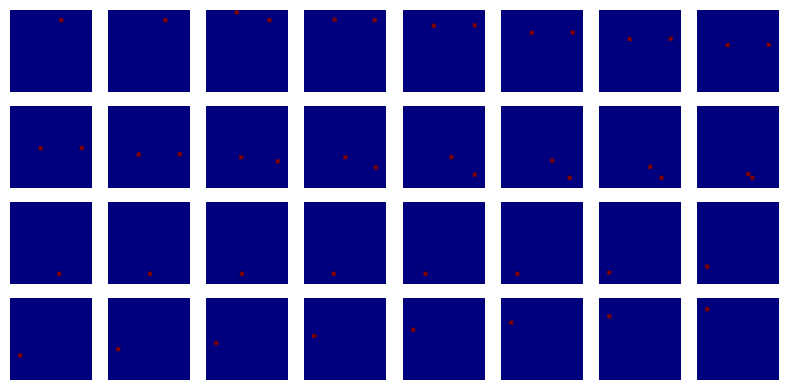

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 4.270052909851074}


100%|██████████| 16/16 [00:01<00:00, 10.74it/s]


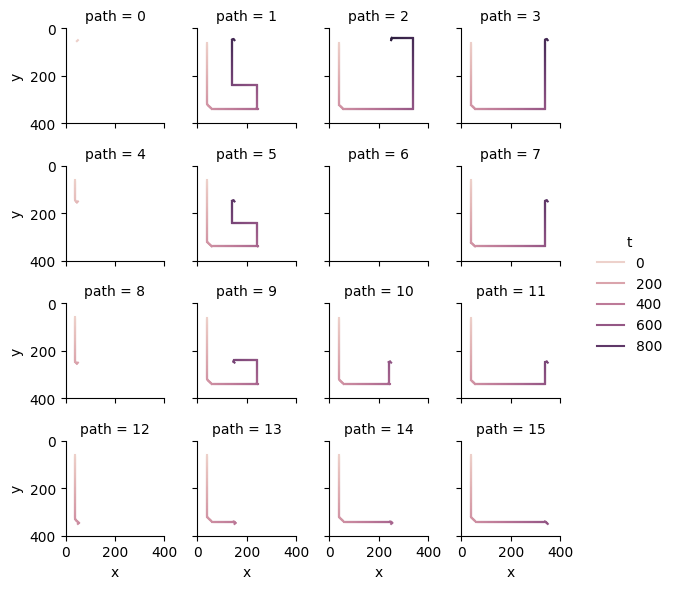

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 21.881122827529907}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.13114261627197266}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.360334396362305}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 0.8168175220489502}


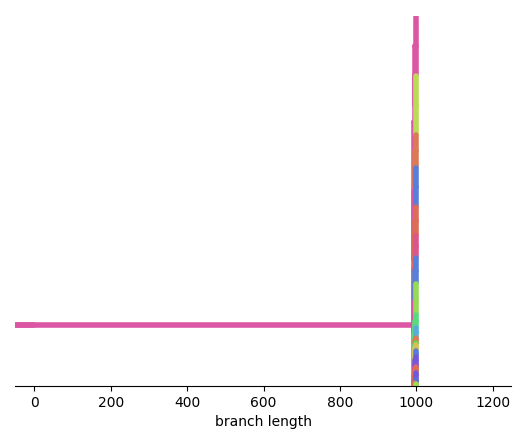

In [10]:
obvs = show_sample_observations(
    SX,
    SY,
    crea_func=np.ones,
    crea_size=crea_size,
    logger=logger,
    mirror_backtrack=True,
    mirror_backtrack_transform=mirror_backtrack_transform,
    num_frames=num_frames,
)
pathsplot(
    [
        build_path(coordinate, obvs, AttributeBoxMax(box_size))
        for coordinate in tqdm(seed_coordinates)
    ],
    xmax=SX,
    ymax=SY,
    col_wrap=4,
)
plt.show()

show_sample_hstrat_tree(
    obvs,
    SX,
    SY,
    dstream_algo=dstream_algo,
    dstream_S=dstream_S,
    logger=logger,
    num_frames=num_frames,
    surface_transform=surface_transform,
)


## `crea_func=np.random.rand` `mirror_backtrack=False`


enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 203 colors in source)


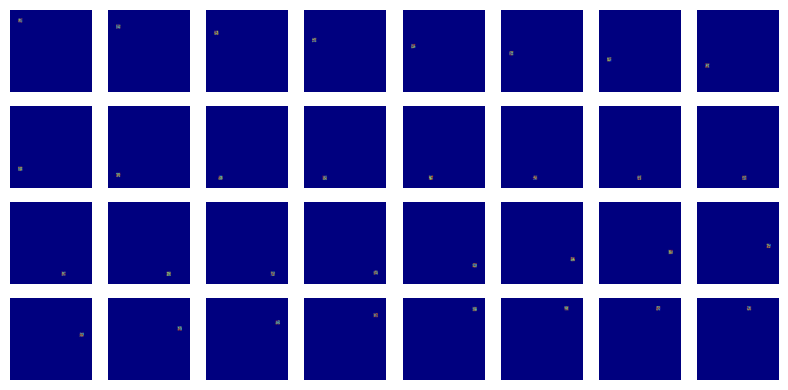

exit log_context_duration for Creating video
!!! {"Creating video": 5.241570949554443}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 210 colors in source)


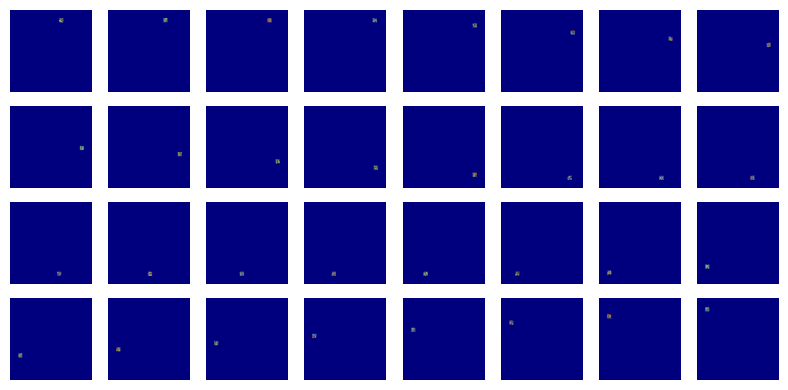

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 6.0230419635772705}


100%|██████████| 16/16 [00:01<00:00,  9.30it/s]


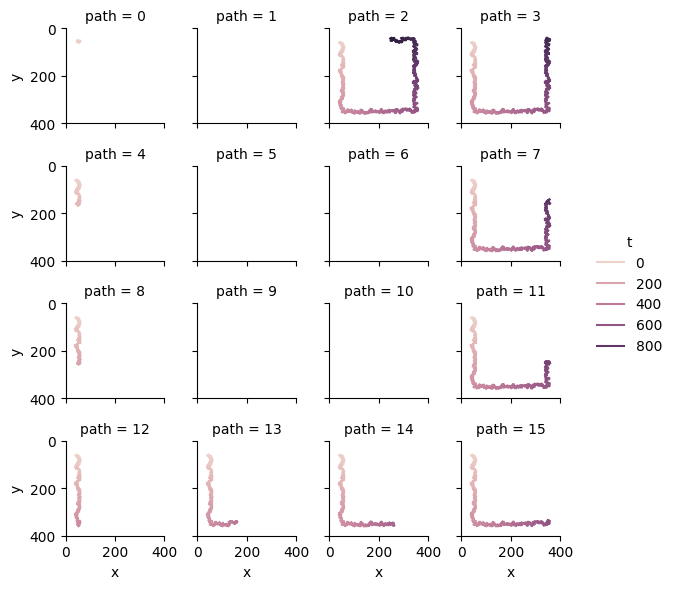

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 21.90675115585327}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.11842751502990723}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.430331468582153}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 0.6772773265838623}


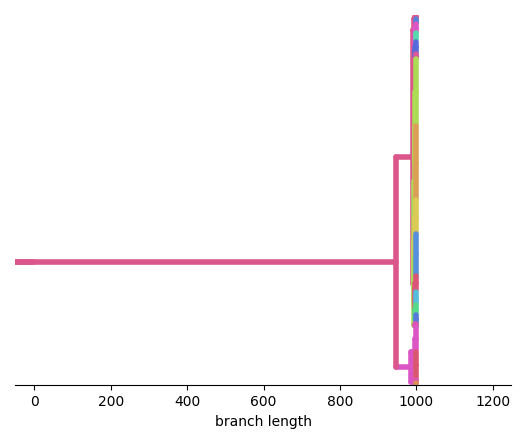

enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 208 colors in source)


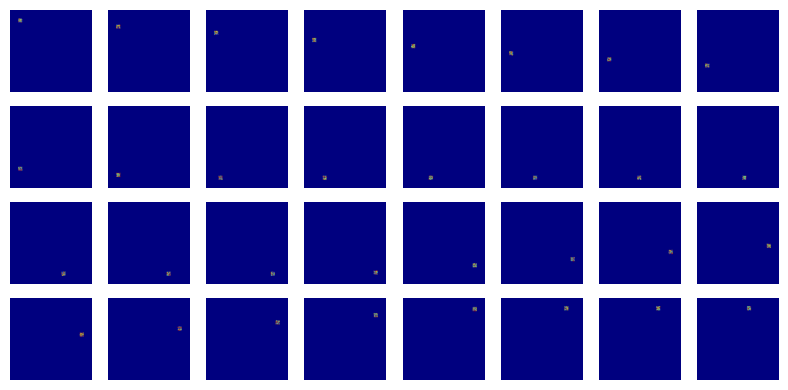

exit log_context_duration for Creating video
!!! {"Creating video": 5.254011631011963}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 212 colors in source)


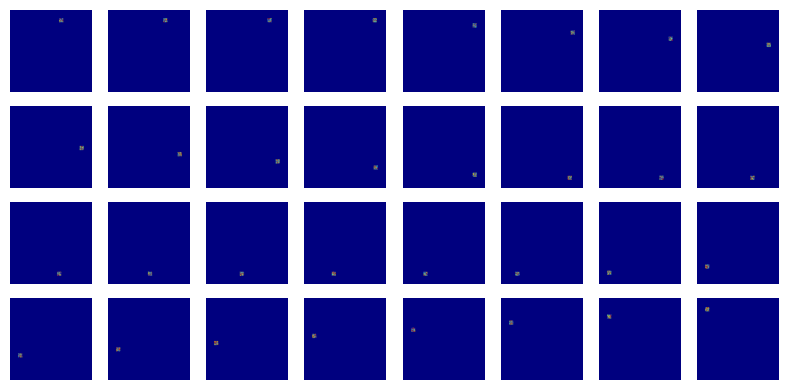

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.197801113128662}


100%|██████████| 16/16 [00:01<00:00,  9.41it/s]


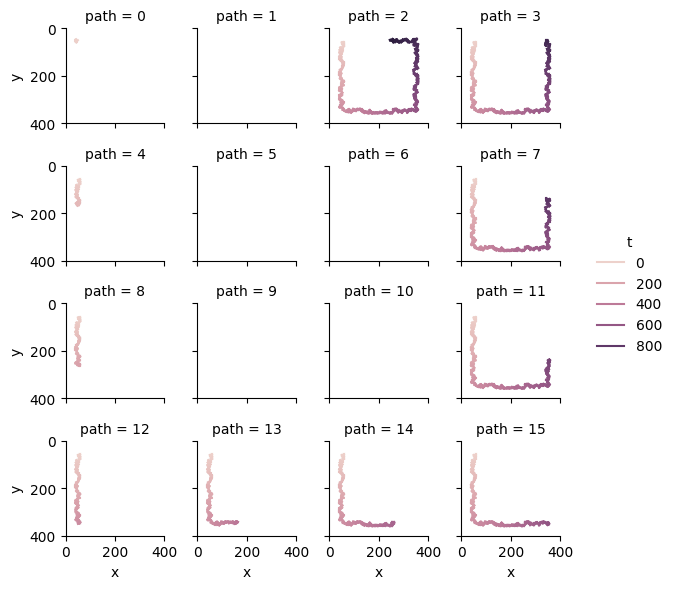

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 21.2308566570282}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.12771844863891602}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.450071573257446}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 0.6281311511993408}


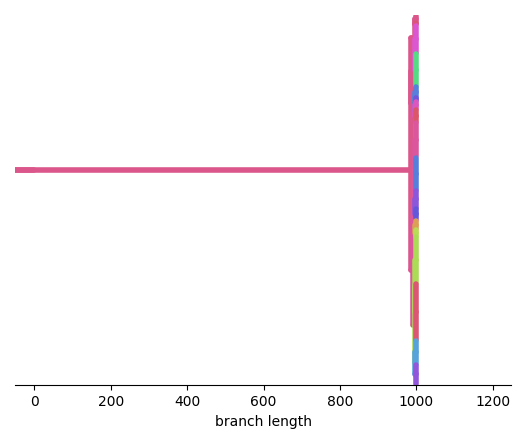

In [11]:
for i in range(2):
    obvs = show_sample_observations(
        SX,
        SY,
        crea_func=lambda x: np.random.rand(*x),
        crea_size=crea_size,
        logger=logger,
        mirror_backtrack=False,
        num_frames=num_frames,
    )
    pathsplot(
        [
            build_path(coordinate, obvs, AttributeBoxMax(box_size))
            for coordinate in tqdm(seed_coordinates)
        ],
        xmax=SX,
        ymax=SY,
        col_wrap=4,
    )
    plt.show()

    show_sample_hstrat_tree(
        obvs,
        SX,
        SY,
        dstream_algo=dstream_algo,
        dstream_S=dstream_S,
        logger=logger,
        num_frames=num_frames,
        surface_transform=surface_transform,
    )


## `crea_func=np.random.rand` `mirror_backtrack=True`


enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 215 colors in source)


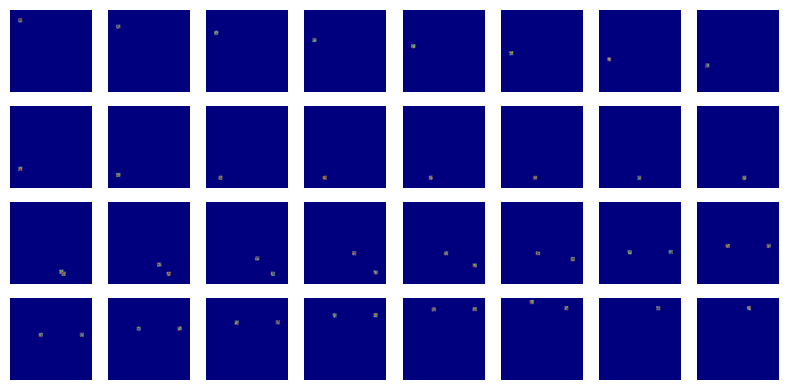

exit log_context_duration for Creating video
!!! {"Creating video": 5.517442941665649}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 217 colors in source)


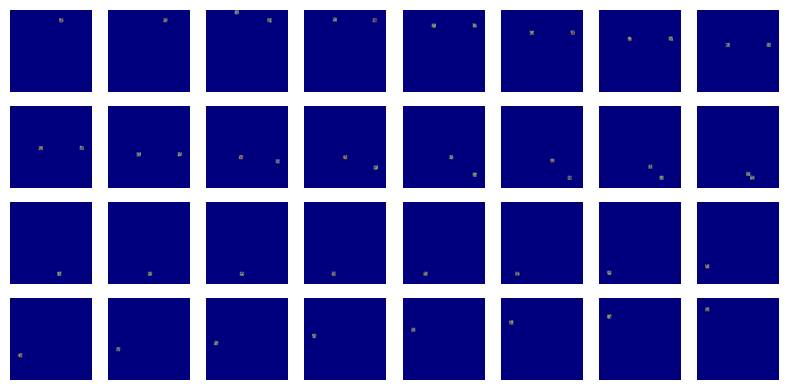

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.467458248138428}


100%|██████████| 16/16 [00:01<00:00,  9.37it/s]


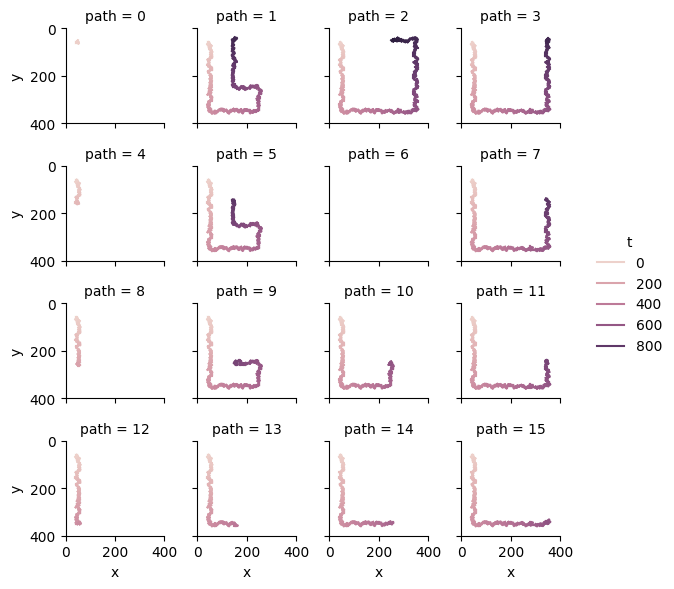

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 21.30462884902954}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.11846494674682617}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.440767765045166}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 0.6297793388366699}


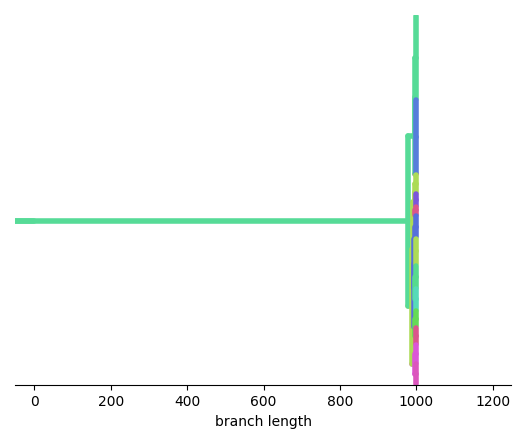

enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 210 colors in source)


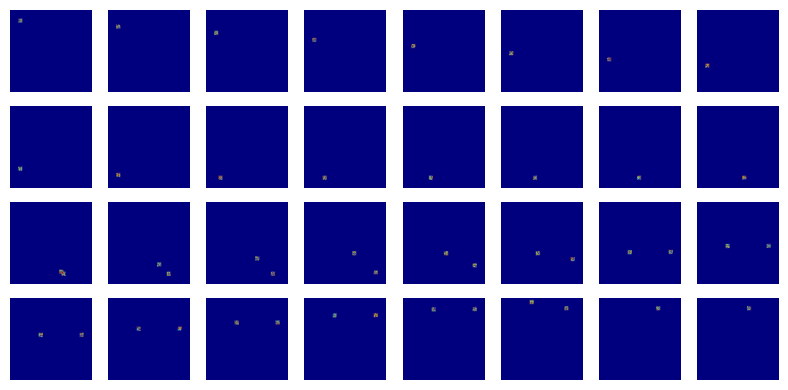

exit log_context_duration for Creating video
!!! {"Creating video": 5.373871803283691}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 205 colors in source)


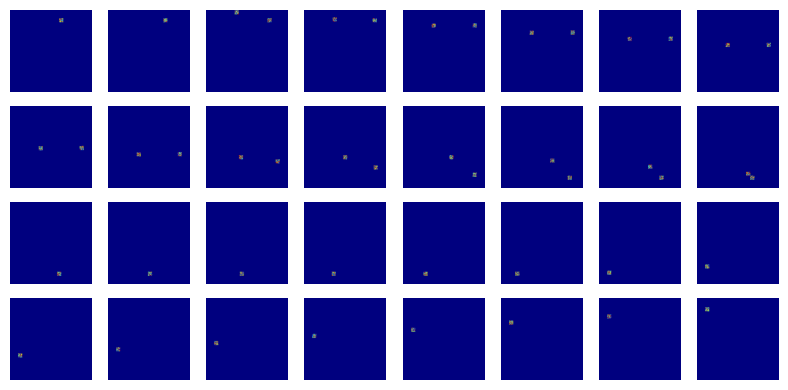

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 6.353416919708252}


100%|██████████| 16/16 [00:01<00:00,  9.43it/s]


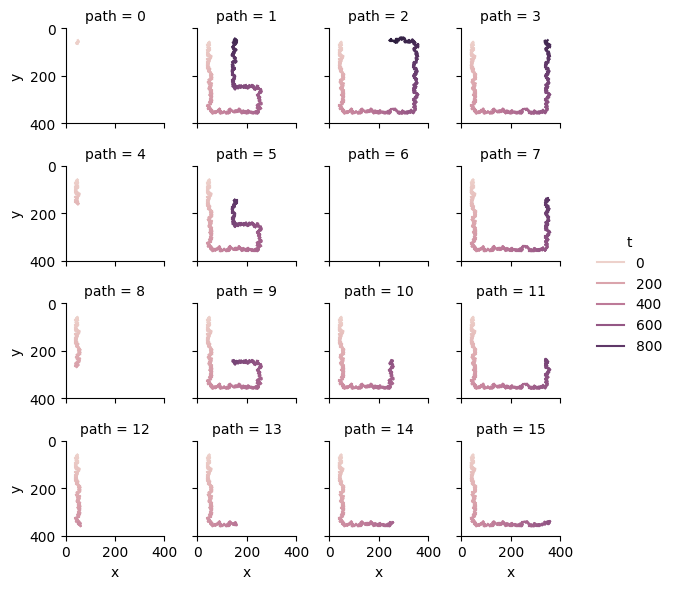

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 21.256168603897095}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.11959505081176758}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.484069347381592}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 0.6684000492095947}


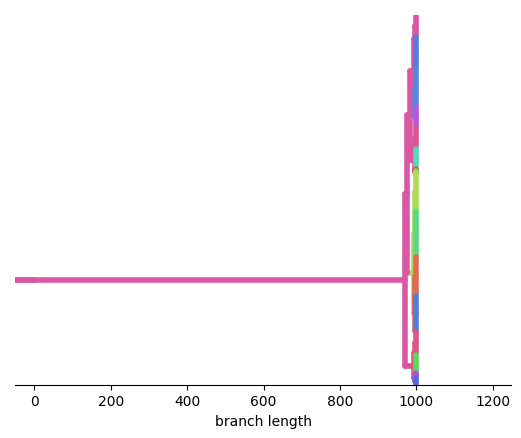

In [12]:
for i in range(2):
    obvs = show_sample_observations(
        SX,
        SY,
        crea_func=lambda x: np.random.rand(*x),
        crea_size=crea_size,
        logger=logger,
        mirror_backtrack=True,
        mirror_backtrack_transform=mirror_backtrack_transform,
        num_frames=num_frames,
    )
    pathsplot(
        [
            build_path(coordinate, obvs, AttributeBoxMax(box_size))
            for coordinate in tqdm(seed_coordinates)
        ],
        xmax=SX,
        ymax=SY,
        col_wrap=4,
    )
    plt.show()

    show_sample_hstrat_tree(
        obvs,
        SX,
        SY,
        dstream_algo=dstream_algo,
        dstream_S=dstream_S,
        logger=logger,
        num_frames=num_frames,
        surface_transform=surface_transform,
    )
